In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# import the necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, SpatialDropout1D, LSTM, GRU, Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold

#Oversampling library
from imblearn.over_sampling import SMOTE
from collections import Counter

# Word2Vec
from gensim.models import Word2Vec, KeyedVectors

#import regular expression
import re

# model evaluation
from imblearn.metrics import classification_report_imbalanced
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve




/Users/salmazainana/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
#Download data 
df = pd.read_csv('cleaned_dataset.csv')
df.columns

Index(['type', 'posts', 'cleaned_posts'], dtype='object')

In [4]:
# replacing ||| with space
df["cleaned_posts"] = df["cleaned_posts"].str.replace(
    r"\|\|\|", " ", regex=True
)

In [5]:

df["is_Extrovert"] = df["type"].apply(
    lambda x: 1 if x[0] == "E" else 0
)
df["is_Intuitive"] = df["type"].apply(
    lambda x: 1 if x[1] == "N" else 0
)
df["is_Thinking"] = df["type"].apply(
    lambda x: 1 if x[2] == "T" else 0
)
df["is_Judging"] = df["type"].apply(
    lambda x: 1 if x[3] == "J" else 0
)

# rearranging the dataframe columns
df = df[
    ["type", "is_Extrovert", "is_Intuitive", "is_Thinking", "is_Judging", "posts", "cleaned_posts"]
]
df.head()

,type,is_Extrovert,is_Intuitive,is_Thinking,is_Judging,posts,cleaned_posts
0,INFJ,0,1,0,1,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,enfp intj moment sportscenter top ten play p...
1,ENTP,1,1,1,0,'I'm finding the lack of me in these posts ver...,im finding lack post alarming sex boring posit...
2,INTP,0,1,1,0,'Good one _____ https://www.youtube.com/wat...,good one course say know thats blessing curse ...
3,INTJ,0,1,1,1,"'Dear INTP, I enjoyed our conversation the o...",dear intp enjoyed conversation day esoteric ga...
4,ENTJ,1,1,1,1,'You're fired.|||That's another silly misconce...,youre fired thats another silly misconception ...


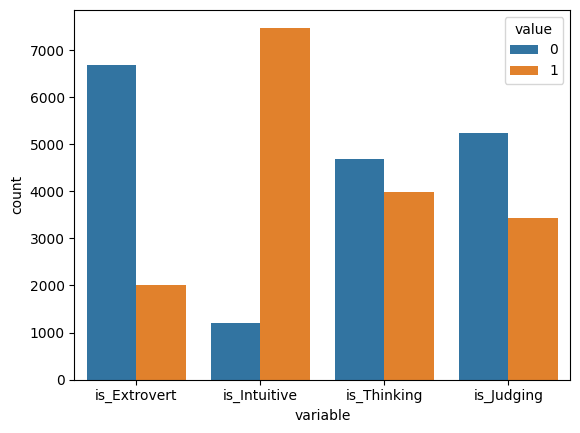

In [6]:
sns.countplot(
    x="variable",
    hue="value",
    data=pd.melt(
        df[["is_Extrovert", "is_Intuitive", "is_Thinking", "is_Judging"]]
    ),
)

plt.show()

<Axes: >

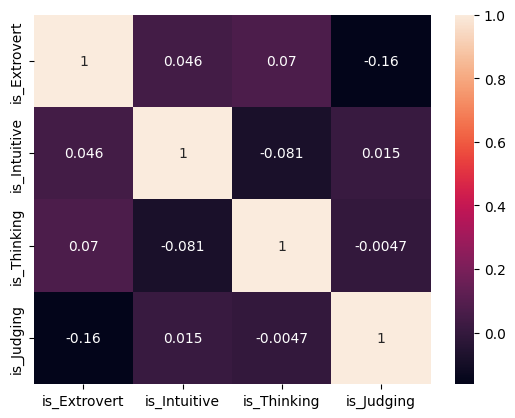

In [7]:
corr = df[
    ["is_Extrovert", "is_Intuitive", "is_Thinking", "is_Judging"]
].corr()
sns.heatmap(corr, annot=True)

In [8]:
#Tockenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['cleaned_posts'])
tokenizer.word_index # Get our learned vocabulary
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)+1 # Total words   
print('Vocabulary size:', VOCAB_SIZE)


#Tockenize the words
X = tokenizer.texts_to_sequences(df['cleaned_posts'])
MAX_SEQ_LENGTH = max(len(seq) for seq in X)
print('Max sequence length:', MAX_SEQ_LENGTH)

#Pad the sequence
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen= MAX_SEQ_LENGTH, padding = 'post') # Pad the sequence to the same length to make it uniform
print('Padded sequence shape:', X.shape)

Vocabulary size: 135303
Max sequence length: 957
Padded sequence shape: (8675, 957)


In [9]:
y = df.iloc[:, 1:5]
y.head()

,is_Extrovert,is_Intuitive,is_Thinking,is_Judging
0,0,1,0,1
1,1,1,1,0
2,0,1,1,0
3,0,1,1,1
4,1,1,1,1


In [10]:
# ensuring that X and y row count matches
print(X.shape)
print(y.shape)

(8675, 957)
(8675, 4)


In [11]:
# setting up the personality dictionary for printing scores for each class
mbti_type = {
    "is_Extrovert": "Extrovert vs Introvert",
    "is_Intuitive": "Intuition vs Sensing",
    "is_Thinking": "Thinking vs Feeling",
    "is_Judging": "Judging vs Perceiving",
}



In [12]:
# Word 2 vec model 
gn_vec_zip_path ="/Users/salmazainana/Downloads/GoogleNews-vectors-negative300.bin"
word2vec_model = KeyedVectors.load_word2vec_format(gn_vec_zip_path, binary=True)

# Create an embedding matrix
embedding_size = 300
print('Embedding size:', embedding_size)

embedding_matrix = np.zeros((VOCAB_SIZE, embedding_size))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model:  # Use word2vec_model directly instead of word2vec_model.wv
        embedding_vector = word2vec_model[word]  # Same here
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Check the shape of the embedding matrix
print('Shape of embedding matrix:', embedding_matrix.shape)

# Check the embedding matrix
print('Embedding matrix[1]:', embedding_matrix[1])

Embedding size: 300
Shape of embedding matrix: (135303, 300)
Embedding matrix[1]: [-0.03662109  0.01452637  0.03515625  0.23046875 -0.20800781  0.26171875
 -0.13183594 -0.08740234  0.07519531  0.03881836 -0.19726562 -0.37109375
 -0.22460938 -0.05029297  0.14648438  0.08398438 -0.0625      0.3828125
  0.05664062 -0.09277344 -0.20898438  0.11035156  0.36132812  0.28710938
 -0.15332031 -0.16113281 -0.3828125  -0.05395508 -0.140625   -0.29101562
  0.18261719  0.09326172 -0.19628906 -0.00500488 -0.07910156  0.296875
 -0.38085938  0.44335938  0.3671875   0.20117188  0.07568359 -0.25585938
  0.1953125   0.10253906  0.23730469  0.00772095  0.1875     -0.20117188
 -0.09277344  0.10107422  0.0246582   0.18457031  0.19824219  0.19140625
 -0.05419922  0.13476562  0.00506592  0.10644531 -0.05322266 -0.18945312
 -0.10498047 -0.01611328 -0.26171875  0.05004883 -0.04882812 -0.3046875
 -0.00799561 -0.14257812 -0.359375    0.3671875   0.10546875  0.40234375
  0.11035156  0.08740234 -0.32226562 -0.058349

In [13]:
kernel_size = 3
filters = 64
hidden_dims = 250 
num_epochs = 30
batch_size = 128

# Conv1D

In [46]:
model = Sequential()
# First we add an embedding layer 
model.add(Embedding(VOCAB_SIZE,embedding_size,weights = [embedding_matrix],input_length=MAX_SEQ_LENGTH)) 
# Adding a 1D convolutional Layer
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu'))
# Max Pooling the Convolutions
model.add(MaxPooling1D())
# Again Computing the Convolutions
model.add(Flatten())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train,y_train, num_epochs, batch_size, validation_split = 0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)], verbose=1)


Epoch 1/128
186/186 [==============================] - 21s 111ms/step - loss: 0.0929 - accuracy: 0.5101 - val_loss: 0.6492 - val_accuracy: 0.5807
Epoch 2/128
186/186 [==============================] - 22s 119ms/step - loss: 0.0093 - accuracy: 0.5913 - val_loss: 0.8246 - val_accuracy: 0.5670
Epoch 3/128
186/186 [==============================] - 24s 129ms/step - loss: 0.0013 - accuracy: 0.6030 - val_loss: 0.8887 - val_accuracy: 0.5922
Epoch 4/128
186/186 [==============================] - 24s 129ms/step - loss: 6.9196e-04 - accuracy: 0.6223 - val_loss: 0.9033 - val_accuracy: 0.6001


In [51]:
model.evaluate(X_test,y_test)[1]*100 # Accuracy of the model


55/55 [==============================] - 1s 13ms/step - loss: 0.8976 - accuracy: 0.5942


59.42363142967224

In [70]:
# y_hat
y_pred = model.predict(X_test)

# Convert the predicted values to a dataframe
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)
y_pred.columns = y_test.columns
y_pred.head()

55/55 [==============================] - 1s 14ms/step


,is_Extrovert,is_Intuitive,is_Thinking,is_Judging
0,0.129543,0.999219,0.999991,0.231109
1,0.285207,0.940836,0.257431,0.375147
2,0.002574,0.999996,0.999884,0.782175
3,0.516470,0.996266,0.039941,0.941826
4,0.018081,0.999077,0.993808,0.606370


In [85]:

y_binary = y_pred.copy()
for type in mbti_type:
    y_binary[type] = y_pred[type].apply(lambda x: 1 if x > 0.5 else 0)

y_binary.head()

,is_Extrovert,is_Intuitive,is_Thinking,is_Judging
0,0,1,1,0
1,0,1,0,0
2,0,1,1,1
3,1,1,0,1
4,0,1,1,1


In [87]:

# precision recall score
average_precision = average_precision_score(y_test, y_pred)

# model evaluation
for type in mbti_type:
    print(f"{mbti_type[type]}")

    print(f"ROC-AUC Score: {roc_auc_score(y_test[type], y_pred[type]):.2f}")
    print(f"Average Precision-Recall Score: {average_precision:.2f}")
 
    #Binary classification report
  
    print(
        f"Geometric Mean Score with ERR: {geometric_mean_score(y_test[type], y_binary[type], average='weighted'):.2f}"
    )
    print(f"classification_report_imbalanced with binary prediction using ERR: {classification_report_imbalanced(y_test[type], y_binary[type])}")


Extrovert vs Introvert
ROC-AUC Score: 0.68
Average Precision-Recall Score: 0.67
Geometric Mean Score with ERR: 0.51
classification_report_imbalanced with binary prediction using ERR:                    pre       rec       spe        f1       geo       iba       sup

          0       0.80      0.94      0.16      0.86      0.39      0.17      1353
          1       0.42      0.16      0.94      0.24      0.39      0.14       382

avg / total       0.72      0.77      0.33      0.72      0.39      0.16      1735

Intuition vs Sensing
ROC-AUC Score: 0.69
Average Precision-Recall Score: 0.67
Geometric Mean Score with ERR: 0.39
classification_report_imbalanced with binary prediction using ERR:                    pre       rec       spe        f1       geo       iba       sup

          0       0.55      0.04      0.99      0.08      0.21      0.04       246
          1       0.86      0.99      0.04      0.92      0.21      0.05      1489

avg / total       0.82      0.86      0.18      0.

In [115]:

# Calculate the Best Threshold for Each Task

best_thresholds = []
accuracies = []

# For each of the 4 binary classifications
for type in mbti_type:
    best_acc = 0
    best_threshold = 0.5
    for threshold in np.linspace(0, 1, 101):
        y_pred_thresh = (y_pred[type] > threshold).astype(int)
        acc = accuracy_score(y_test[type], y_pred_thresh)
        if acc > best_acc:
            best_acc = acc
            best_threshold = threshold
    best_thresholds.append(best_threshold)
    accuracies.append(best_acc)
    print(f"For classification task {mbti_type[type]}: Best Threshold = {best_threshold}, Accuracy = {best_acc}")


For classification task Extrovert vs Introvert: Best Threshold = 0.93, Accuracy = 0.7804034582132565
For classification task Intuition vs Sensing: Best Threshold = 0.33, Accuracy = 0.8599423631123919
For classification task Thinking vs Feeling: Best Threshold = 0.59, Accuracy = 0.792507204610951
For classification task Judging vs Perceiving: Best Threshold = 0.68, Accuracy = 0.6593659942363113


Text(0.5, 1.0, 'ROC Curve')

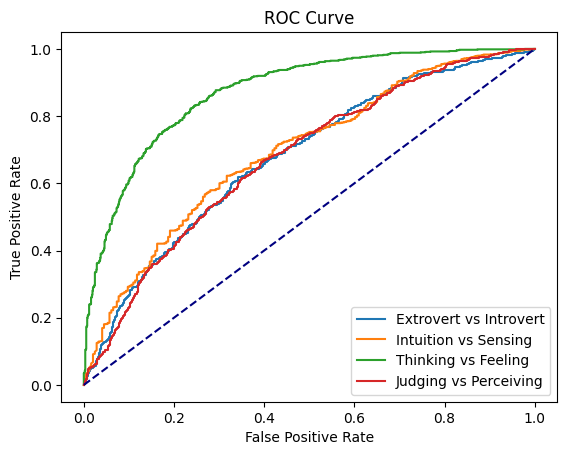

In [100]:
# ROC curve
for type in mbti_type:
    fpr, tpr, thresholds = roc_curve(y_test[type], y_pred[type])
    plt.plot(fpr, tpr, label=f"{mbti_type[type]}")
#Random Guess Line
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")

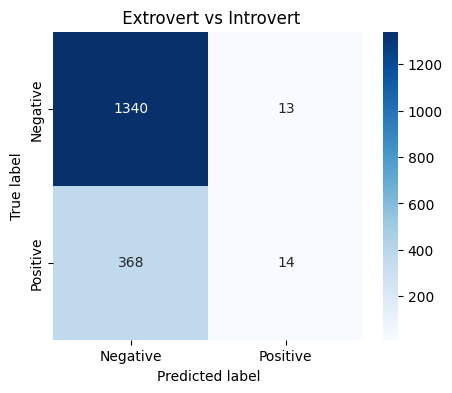

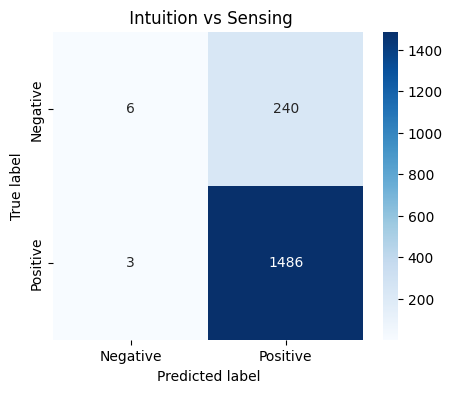

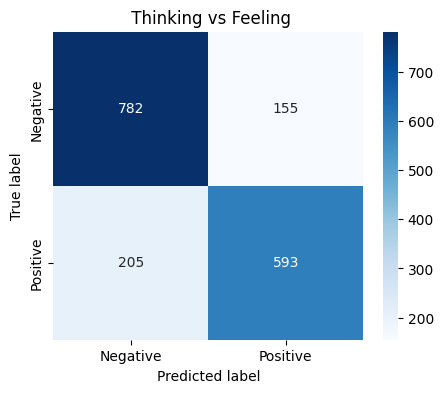

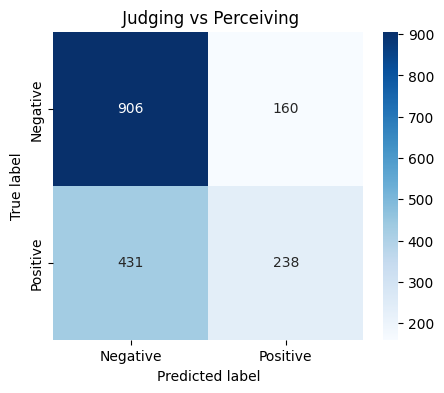

In [113]:
# Confusion Matrix
# For each task
for type, threshold in zip(mbti_type, best_thresholds):
    y_pred_binary = (y_pred[type] > threshold).astype(int)
    cm = confusion_matrix(y_test[type], y_pred_binary)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(f" {mbti_type[type]}")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [117]:
# model evaluation
for type, threshold in zip(mbti_type, best_thresholds):
    y_pred_binary = (y_pred[type] > threshold).astype(int)   

    #Binary classification report  
    print(
        f"Geometric Mean Score with best threshhold: {geometric_mean_score(y_test[type], y_pred_binary, average='weighted'):.2f}"
    )
    print(f"classification_report_imbalanced with binary prediction using ERR: {classification_report_imbalanced(y_test[type], y_pred_binary)}")

Geometric Mean Score with ERR: 0.44
classification_report_imbalanced with binary prediction using ERR:                    pre       rec       spe        f1       geo       iba       sup

          0       0.78      0.99      0.04      0.88      0.19      0.04      1353
          1       0.52      0.04      0.99      0.07      0.19      0.03       382

avg / total       0.73      0.78      0.25      0.70      0.19      0.04      1735

Geometric Mean Score with ERR: 0.37
classification_report_imbalanced with binary prediction using ERR:                    pre       rec       spe        f1       geo       iba       sup

          0       0.67      0.02      1.00      0.05      0.16      0.02       246
          1       0.86      1.00      0.02      0.92      0.16      0.03      1489

avg / total       0.83      0.86      0.16      0.80      0.16      0.03      1735

Geometric Mean Score with ERR: 0.79
classification_report_imbalanced with binary prediction using ERR:                    pr

# Conv1D and LSTM


In [14]:
model2 = Sequential()
# First we add an embedding layer 
model2.add(Embedding(VOCAB_SIZE,embedding_size,weights = [embedding_matrix],input_length=MAX_SEQ_LENGTH)) 
# Adding a 1D convolutional Layer
model2.add(Conv1D(filters, kernel_size, padding='valid', activation='relu'))
# Max Pooling the Convolutions
model2.add(MaxPooling1D())
# Again Computing the Convolutions
# Adding LSTM layer
model2.add(LSTM(hidden_dims))
model2.add(Flatten())
model2.add(Dense(hidden_dims, activation='relu'))
model2.add(Dense(4, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model2.fit(X_train,y_train, num_epochs, batch_size, validation_split = 0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)], verbose=1)


Epoch 1/128
186/186 [==============================] - 107s 569ms/step - loss: 0.5844 - accuracy: 0.6553 - val_loss: 0.5754 - val_accuracy: 0.6513
Epoch 2/128
186/186 [==============================] - 109s 586ms/step - loss: 0.5787 - accuracy: 0.6572 - val_loss: 0.5841 - val_accuracy: 0.6513
Epoch 3/128
186/186 [==============================] - 106s 567ms/step - loss: 0.5780 - accuracy: 0.6572 - val_loss: 0.5759 - val_accuracy: 0.6513
Epoch 4/128
186/186 [==============================] - 108s 581ms/step - loss: 0.5783 - accuracy: 0.6572 - val_loss: 0.5757 - val_accuracy: 0.6513


In [17]:
model2.evaluate(X_test,y_test)[1]*100 # Accuracy of the model


55/55 [==============================] - 11s 203ms/step - loss: 0.5744 - accuracy: 0.6594


65.93660116195679

55/55 [==============================] - 11s 200ms/step
Extrovert vs Introvert
ROC-AUC Score: 0.50
Average Precision-Recall Score: 0.48
Geometric Mean Score with ERR: 0.41
classification_report_imbalanced with binary prediction using ERR:                    pre       rec       spe        f1       geo       iba       sup

          0       0.78      1.00      0.00      0.88      0.00      0.00      1353
          1       0.00      0.00      1.00      0.00      0.00      0.00       382

avg / total       0.61      0.78      0.22      0.68      0.00      0.00      1735

Intuition vs Sensing
ROC-AUC Score: 0.50
Average Precision-Recall Score: 0.48
Geometric Mean Score with ERR: 0.35
classification_report_imbalanced with binary prediction using ERR:                    pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      1.00      0.00      0.00      0.00       246
          1       0.86      1.00      0.00      0.92      0.00      0.00      

/Users/salmazainana/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/salmazainana/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/salmazainana/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

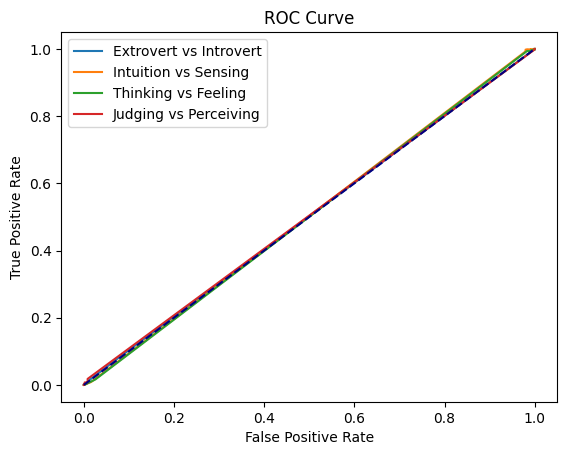

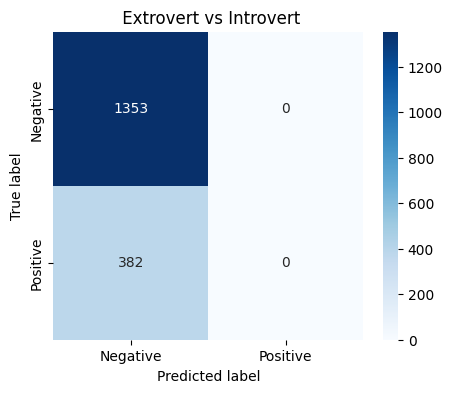

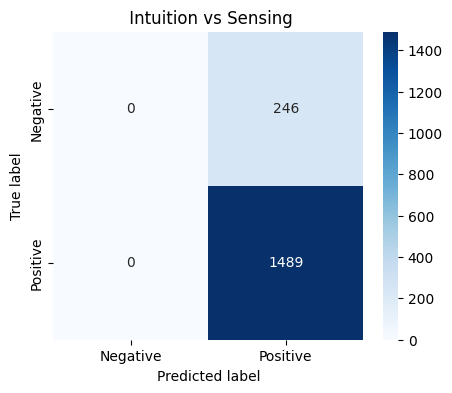

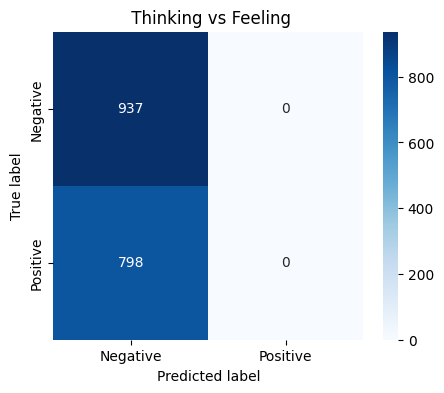

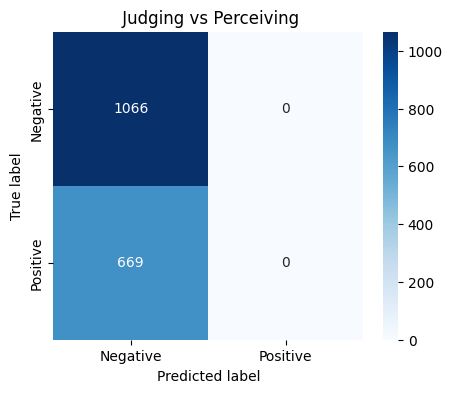

Geometric Mean Score with best threshhold: 0.41
classification_report_imbalanced with binary prediction using ERR:                    pre       rec       spe        f1       geo       iba       sup

          0       0.78      1.00      0.00      0.88      0.00      0.00      1353
          1       0.00      0.00      1.00      0.00      0.00      0.00       382

avg / total       0.61      0.78      0.22      0.68      0.00      0.00      1735

Geometric Mean Score with best threshhold: 0.35
classification_report_imbalanced with binary prediction using ERR:                    pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      1.00      0.00      0.00      0.00       246
          1       0.86      1.00      0.00      0.92      0.00      0.00      1489

avg / total       0.74      0.86      0.14      0.79      0.00      0.00      1735

Geometric Mean Score with best threshhold: 0.50
classification_report_imbalanced with binary predict

/Users/salmazainana/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/salmazainana/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/salmazainana/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [19]:
# y_hat
y_pred = model2.predict(X_test)

# Convert the predicted values to a dataframe
y_pred = pd.DataFrame(y_pred, columns=y_test.columns)
y_pred.columns = y_test.columns
y_pred.head()

y_binary = y_pred.copy()
for type in mbti_type:
    y_binary[type] = y_pred[type].apply(lambda x: 1 if x > 0.5 else 0)

y_binary.head()

# precision recall score
average_precision = average_precision_score(y_test, y_pred)

# model evaluation
for type in mbti_type:
    print(f"{mbti_type[type]}")

    print(f"ROC-AUC Score: {roc_auc_score(y_test[type], y_pred[type]):.2f}")
    print(f"Average Precision-Recall Score: {average_precision:.2f}")
 
    #Binary classification report
  
    print(
        f"Geometric Mean Score with ERR: {geometric_mean_score(y_test[type], y_binary[type], average='weighted'):.2f}"
    )
    print(f"classification_report_imbalanced with binary prediction using ERR: {classification_report_imbalanced(y_test[type], y_binary[type])}")

# Calculate the Best Threshold for Each Task

best_thresholds = []
accuracies = []

# For each of the 4 binary classifications
for type in mbti_type:
    best_acc = 0
    best_threshold = 0.5
    for threshold in np.linspace(0, 1, 101):
        y_pred_thresh = (y_pred[type] > threshold).astype(int)
        acc = accuracy_score(y_test[type], y_pred_thresh)
        if acc > best_acc:
            best_acc = acc
            best_threshold = threshold
    best_thresholds.append(best_threshold)
    accuracies.append(best_acc)
    print(f"For classification task {mbti_type[type]}: Best Threshold = {best_threshold}, Accuracy = {best_acc}")
    
# ROC curve
for type in mbti_type:
    fpr, tpr, thresholds = roc_curve(y_test[type], y_pred[type])
    plt.plot(fpr, tpr, label=f"{mbti_type[type]}")
#Random Guess Line
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("ROC Curve")

# Confusion Matrix
# For each task
for type, threshold in zip(mbti_type, best_thresholds):
    y_pred_binary = (y_pred[type] > threshold).astype(int)
    cm = confusion_matrix(y_test[type], y_pred_binary)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(f" {mbti_type[type]}")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# model evaluation
for type, threshold in zip(mbti_type, best_thresholds):
    y_pred_binary = (y_pred[type] > threshold).astype(int)   

    #Binary classification report  
    print(
        f"Geometric Mean Score with best threshhold: {geometric_mean_score(y_test[type], y_pred_binary, average='weighted'):.2f}"
    )
    print(f"classification_report_imbalanced with binary prediction using ERR: {classification_report_imbalanced(y_test[type], y_pred_binary)}")